Almost all the error comes from the CNOT gates. Lets investigate whether this varies with beta

In [21]:
import pandas as pd

## Hardware

In [22]:
run_on_hardware = False

### Set up server

In [23]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import Parameter

# Make the circuit
# Can initialise it all now and pass in a parameter 
def make_circuit(gamma):
    qc = QuantumCircuit(2)
    # gamma = Parameter("angle")
    # some hadamard gates first to ensure entanglement
    qc.h(0)
    qc.h(1)
    qc.rzz(2 * gamma, 0, 1)  # Virtual Rz(2γ)
    qc.metadata = {"gamma": gamma}  # Store gamma value
    qc.measure_all()
    return qc

# details to allow it to run later
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")

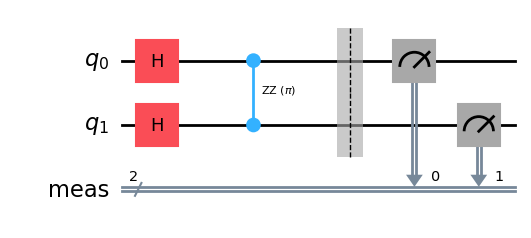

In [24]:
circ = make_circuit(gamma=np.pi/2)
circ.draw("mpl")

### submit to run on ibm hardware

In [25]:
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
# pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
from qiskit_ibm_runtime import Batch
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
backend = service.backend("ibm_brisbane")
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Define rotation angles to test
gamma_values = np.pi*np.linspace(0, 1, 20)  # Test 50 angles between 0 and π

# some parameters
repeat_num = 1
shots = 2**15
poss_outcomes = ["00", "01", "10", "11"]
name_per_outc = ["gamma"] + [f"rep{rep_num}" for rep_num in range(repeat_num)]
isa_all = []
count = 0
if run_on_hardware:
    with Batch(backend=backend) as batch:
        sampler = Sampler(mode=batch) #Sampler(mode=simulator)
        for repeats in range(repeat_num):
            error_rates = []
            for gamma_val in gamma_values:
                count += 1
                # noise
                # qc.assign_parameters({gamma: gamma_val})
                qc = make_circuit(gamma=gamma_val)
                isa_qc = pm_noisy.run(qc)
                isa_all.append(isa_qc)

        job = sampler.run(isa_all, shots=shots)

### Fetch results from ibm server
Easiest to just grab job ids manually - know it will keep on working

In [26]:
job_ids_1 = ["czkc0h2qw630008tbfjg", "czkc0b1qw630008tbfg0",
"czkc030qw630008tbfd0","czkbzyfp3xeg008h50mg",
"czkbzszp3xeg008h50j0","czkbznepj4bg008yvaqg",
"czkbzddpj4bg008yvahg","czkbz8na980g008hgx80",
"czkbz44qw630008tbewg","czkbyv3qw630008tbes0",
"czkbymj112c0008amy2g","czkbydhpj4bg008yva5g",
"czkby91112c0008amxtg","czkby08qw630008tbeag",
"czkbxt7a980g008hgwng","czkbxnpp3xeg008h4z5g",
"czkbxe5p3xeg008h4z10","czkbx6mtj3e0008jprkg",
"czkbx64tj3e0008jprhg","czkbx5ma980g008hgwbg"]

In [27]:
def split_results_by_outcome(results, results_dict, gamma_val, repeats):
    for outcome in poss_outcomes:
        outcome_num = results[0].data.meas.get_counts().get(outcome, 0)
        expected_num = results[0].data.meas.num_shots / 4
        outcome_diff = (outcome_num - expected_num) / expected_num
        gamma_rounded = float(gamma_val)
        results_dict[outcome]["gamma"].append(gamma_rounded)
        results_dict[outcome][f"rep{repeats}"].append(outcome_diff)
        
    return results_dict


def process_batch_results(ids:list[str], repeat_num=1):
    """from list of job id strings get the results from ibm
    server and put them into a dict to be plotted"""
    count = 0
    results_dict = {outcome: {name : [] for name in name_per_outc} for outcome in poss_outcomes}
    for repeats in range(repeat_num):
        for gamma_val in gamma_values:      
            # expect them all with equal probability
            # produce error plots for each possibility
            results = service.job(job_id=ids[count]).result()
            count += 1
            results_dict = split_results_by_outcome(results, 
                                                    results_dict, 
                                                    gamma_val, 
                                                    repeats)
                                                    
    return results_dict


In [28]:
results_dict = process_batch_results(job_ids_1)
print(results_dict)

{'00': {'gamma': [0.0, 0.16534698176788384, 0.3306939635357677, 0.4960409453036515, 0.6613879270715354, 0.8267349088394192, 0.992081890607303, 1.1574288723751869, 1.3227758541430708, 1.4881228359109546, 1.6534698176788385, 1.8188167994467224, 1.984163781214606, 2.14951076298249, 2.3148577447503738, 2.4802047265182576, 2.6455517082861415, 2.810898690054025, 2.9762456718219092, 3.141592653589793], 'rep0': [-0.0028076171875, -0.013916015625, 0.000244140625, 0.0120849609375, 0.020263671875, 0.03765869140625, 0.04644775390625, 0.0518798828125, 0.03973388671875, 0.03515625, 0.00506591796875, -0.01275634765625, -0.00701904296875, -0.042724609375, -0.0345458984375, -0.029541015625, -0.05133056640625, -0.04254150390625, -0.03509521484375, -0.03045654296875]}, '01': {'gamma': [0.0, 0.16534698176788384, 0.3306939635357677, 0.4960409453036515, 0.6613879270715354, 0.8267349088394192, 0.992081890607303, 1.1574288723751869, 1.3227758541430708, 1.4881228359109546, 1.6534698176788385, 1.818816799446722

In [64]:
# Prepare data for the dataframe
data = []
for result_type, values in results_dict.items():
    for gamma, value in zip(values["gamma"], values["rep0"]):
        data.append({"result_type": result_type, "gamma": gamma, "value": value,
                     "repeat": 0})

# Create the dataframe
df_0 = pd.DataFrame(data)
print(df_0)

   result_type     gamma     value  repeat
0           00  0.000000 -0.002808       0
1           00  0.165347 -0.013916       0
2           00  0.330694  0.000244       0
3           00  0.496041  0.012085       0
4           00  0.661388  0.020264       0
..         ...       ...       ...     ...
75          11  2.480205 -0.013367       0
76          11  2.645552  0.010803       0
77          11  2.810899  0.009094       0
78          11  2.976246  0.022461       0
79          11  3.141593  0.026428       0

[80 rows x 4 columns]


In [65]:
# extract for batch runs too
batch_id1 = "czqb9geqnmvg008tpg10"
batch_id2_part1 = "czqb954nhqag008sbekg"
batch_id2_part2 = "czqb650kzhn0008bv4d0"

# extract batchid1
batch_id1_results = service.job(job_id=batch_id1).result()
batch_id2_part1_results = service.job(job_id=batch_id2_part1).result()
batch_id2_part2_results = service.job(job_id=batch_id2_part2).result()

In [66]:
import pandas as pd

def extract_dataframe_from_results(raw_results, repeat_num):
    """
    Extracts a DataFrame with columns: result_type, gamma, value
    from the raw_results object.
    """
    data = []
    
    # Iterate through the results in raw_results
    for result in raw_results:
        gamma = result.metadata['circuit_metadata']['gamma']
        for result_type, value in result.data.meas.get_counts().items():
            expected_result = (raw_results[0].data.meas.num_shots / 4)
            frac_off = (value - expected_result) / expected_result
            data.append({
                'result_type': result_type,
                'gamma': gamma,
                'value': frac_off,
                'repeat': repeat_num
            })
    
    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)
    return df

df_1 = extract_dataframe_from_results(batch_id1_results, repeat_num=1)
df_2_1 = extract_dataframe_from_results(batch_id2_part1_results, repeat_num=2)
df_2_2 = extract_dataframe_from_results(batch_id2_part2_results, repeat_num=2)

In [67]:
df_concat = pd.concat([df_0, df_1, df_2_1, df_2_2], axis=0)

In [68]:
df_all_results = df_concat.copy()
df_all_results["gamma"] /= (np.pi)
df_all_results["gamma"] = df_all_results["gamma"].round(4)
df_all_results = df_all_results.sort_values(by=["result_type", "gamma"]).set_index(["result_type", "gamma"])
print(df_all_results)

                       value  repeat
result_type gamma                   
00          0.0000 -0.002808       0
            0.0000 -0.018555       1
            0.0000  0.005615       2
            0.0526 -0.013916       0
            0.0526 -0.053589       1
...                      ...     ...
11          0.9474  0.024902       1
            0.9474  0.058960       2
            1.0000  0.026428       0
            1.0000  0.041016       1
            1.0000  0.038696       2

[240 rows x 2 columns]


In [69]:
df_all_results.to_csv("data/2_processed/rzz_investigation_results.csv")

## Post Analysis

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
df_all_results = pd.read_csv("data/2_processed/rzz_investigation_results.csv")

### stats
ANOVA statistical test to look for correlations

In [72]:
from scipy.stats import f_oneway

def perform_anova_test(df):
    """
    Perform ANOVA tests on a subset of the data in df_all_results.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.

    Returns:
    dict: A dictionary containing the ANOVA results for each gamma value.
    """
    # Filter the dataframe for the specified result_type subset
    # Group by gamma and perform ANOVA for each gamma value
    anova_results = {}
    values_repeated_all = []
    for gamma, group in df.groupby("gamma"):
        # Extract values for each repeat
        values_by_repeat = group["value"].values 
        values_repeated_all.append(values_by_repeat)        
    # Perform ANOVA test
    f_stat, p_value = f_oneway(*values_repeated_all)

    return f_stat, p_value

# Example usage
df_filtered = df_all_results[df_all_results["result_type"] == 0]
anova_results = perform_anova_test(df_filtered)
print(anova_results)

(np.float64(0.4054035667163032), np.float64(0.9813521279771404))


### plot

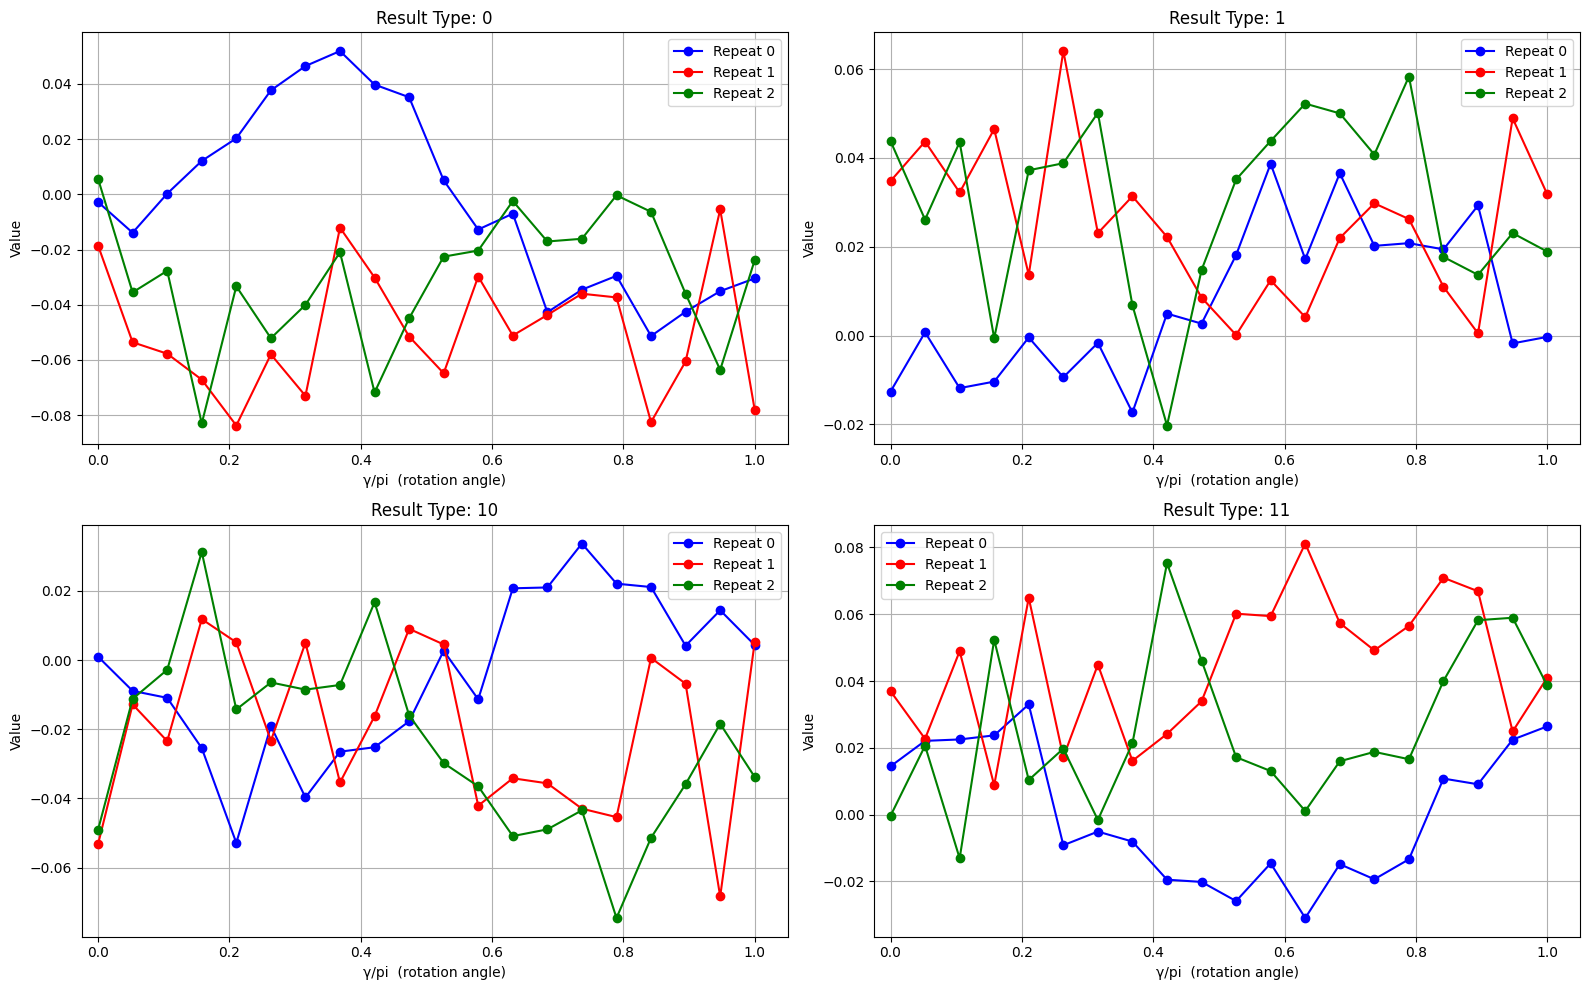

In [73]:
def plot_results_by_repeat(df_all_results, fname):
    """
    Plots subplots for each result_type from the DataFrame df_all_results.
    Each subplot has gamma on the x-axis and separate lines for each repeat.
    """
    # Reset the index to work with grouped data
    df_reset = df_all_results.reset_index()

    # Get unique result_types and repeats for subplots
    result_types = df_reset["result_type"].unique()
    repeats = df_reset["repeat"].unique()

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    clrs = ["b", "r", "g"]  # Colors for repeats
    axes_flat = axes.flatten()

    # Plot for each result_type
    for i, (ax, result_type) in enumerate(zip(axes_flat, result_types)):
        # Filter data for the current result_type
        data = df_reset[df_reset["result_type"] == result_type]

        # Plot each repeat with a different color
        for j, repeat in enumerate(repeats):
            repeat_data = data[data["repeat"] == repeat]
            ax.plot(
                repeat_data["gamma"], repeat_data["value"],
                label=f"Repeat {repeat}", color=clrs[j], marker="o"
            )

        # Set labels and title
        ax.set_title(f"Result Type: {result_type}")
        ax.set_xlabel(r"γ/pi  (rotation angle)")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)
        ax.set_xlim([-0.025, 1.05])

    # Adjust layout and save the plot
    plt.tight_layout()
    # plt.savefig(fname, bbox_inches="tight")

# Call the function to plot
plot_results_by_repeat(df_all_results, fname="plots/rzz_err_by_repeat.png")

In [74]:
df_all_results

,result_type,gamma,value,repeat
0,0,0.0000,-0.002808,0
1,0,0.0000,-0.018555,1
2,0,0.0000,0.005615,2
3,0,0.0526,-0.013916,0
4,0,0.0526,-0.053589,1
...,...,...,...,...
235,11,0.9474,0.024902,1
236,11,0.9474,0.058960,2
237,11,1.0000,0.026428,0
238,11,1.0000,0.041016,1


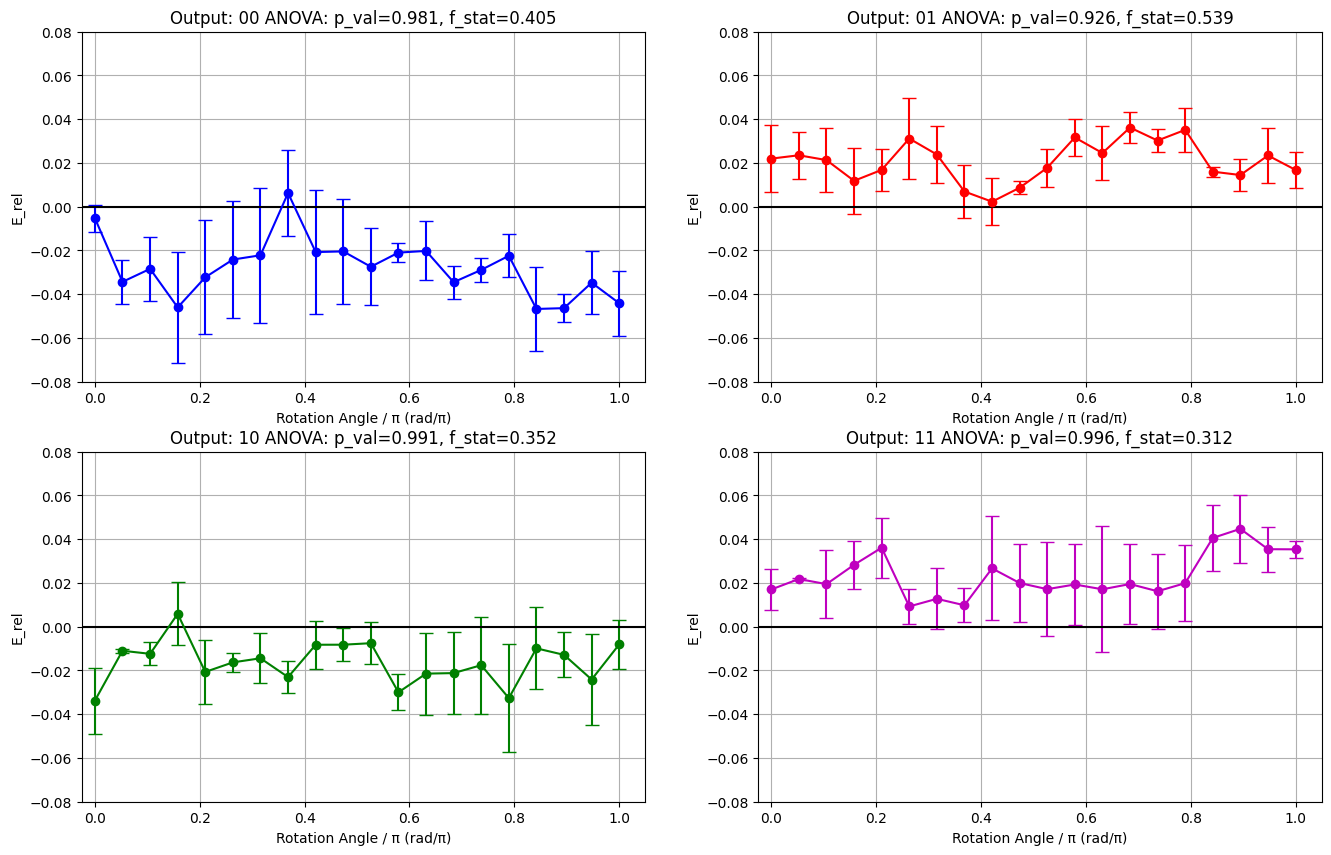

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_with_error_bars(df_all_results, fname):
    """
    Plots subplots for each result_type from the DataFrame df_all_results.
    Each subplot has gamma on the x-axis and the average value on the y-axis,
    with error bars representing the standard deviation over repeats.
    """
    # Reset the index to work with grouped data
    df_reset = df_all_results.reset_index()

    # Group by result_type and gamma, and calculate mean and standard deviation
    grouped = df_reset.groupby(["result_type", "gamma"]).agg(
        mean_value=("value", "mean"),
        std_value=("value", "std")
    ).reset_index()

    # Get unique result_types for subplots
    result_types = grouped["result_type"].unique()

    # Create subplots
    fig, axes = plt.subplots(2,2, 
                             figsize=(16, 10))

    # Ensure axes is iterable even if there's only one subplot
    if len(result_types) == 1:
        axes = [axes]
    clrs = ["b", "r", "g", "m"]
    # ylims = [-0.1, 0.1]
    # Plot for each result_type
    for i, (ax, result_type) in enumerate(zip(axes.flatten(), result_types)):
        # Filter data for the current result_type
        data = grouped[grouped["result_type"] == result_type]

        # do the anova test
        data_filtered_anova = df_reset[df_reset["result_type"] == result_type].copy()
        f_stat, p_value = perform_anova_test(df=data_filtered_anova)
        f_stat, p_value = round(f_stat, 3), round(p_value, 3)
        # Plot with error bars
        ax.errorbar(
            data["gamma"], data["mean_value"], yerr=data["std_value"]/2,
            fmt='o-', capsize=5, label=result_type,
            color=clrs[i]
        )

        # Set labels and title
        if len(str(result_type)) == 1:
            result_type = "0" + str(result_type)
        ax.set_title(f"Output: {result_type} ANOVA: p_val={p_value}, f_stat={f_stat}")
        ax.set_xlabel("Gamma")
        ax.set_ylabel("Average Value")
        # ax.legend()
        ax.grid("on")
        ax.set_xlabel(r"Rotation Angle / π (rad/π)")  
        ax.set_ylabel("E_rel")
        ax.set_ylim([-0.08, 0.08])

        ax.plot([min(ax.get_xlim()), max(ax.get_xlim())], 
                [0, 0], color="k", linewidth=1.5)
        ax.set_xlim([-0.025, 1.05])


    # Adjust layout
    # plt.savefig(fname, bbox_inches="tight")

# Call the function to plot
plot_results_with_error_bars(df_all_results, fname="plots/rzz_err_by_angle_hardware_3reps.png")

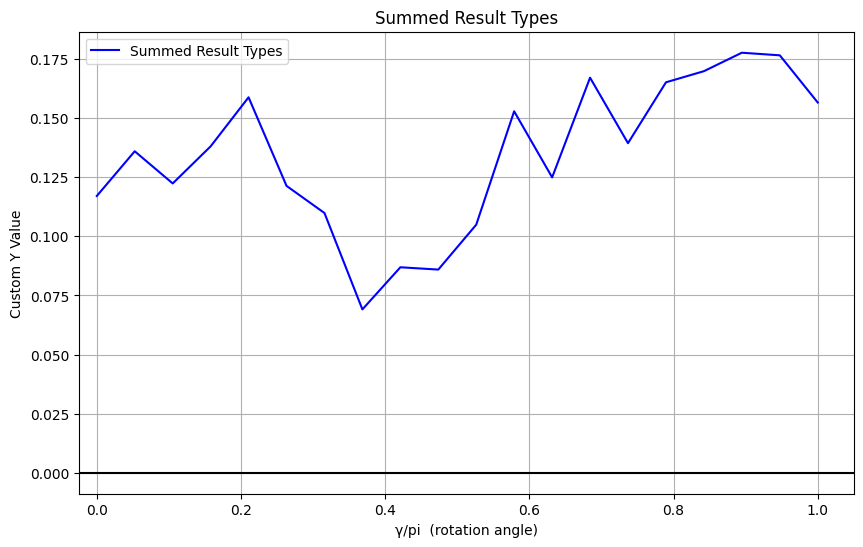

In [76]:
def plot_results_with_custom_y(df_all_results, fname):
    """
    Plots subplots for each result_type from the DataFrame df_all_results.
    Each subplot has gamma on the x-axis and y-values calculated as 
    0.5 * abs(sum(repeats)).
    """
    # Reset the index to work with grouped data
    df_reset = df_all_results.reset_index()

    # Group by result_type and gamma, and calculate the custom y-value
    grouped = df_reset.groupby(["result_type", "gamma"]).agg(
        custom_y=("value", lambda x: 0.5 * abs(x.sum()))
    ).reset_index()


    # Sum over result types as well
    grouped = grouped.groupby("gamma").agg(
        custom_y=("custom_y", lambda x: abs(x.sum()))
    ).reset_index()

    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        grouped["gamma"], grouped["custom_y"],
        label="Summed Result Types", color="b"
    )

    # Set labels and title
    ax.set_title("Summed Result Types")
    ax.set_xlabel("Gamma")
    ax.set_ylabel("Custom Y (0.5 * abs(sum(repeats)))")
    ax.legend()
    ax.grid("on")
    ax.set_xlabel(r"γ/pi  (rotation angle)")
    ax.set_ylabel("Custom Y Value")
    ax.plot([min(ax.get_xlim()), max(ax.get_xlim())], 
            [0, 0], color="k", linewidth=1.5)
    ax.set_xlim([-0.025, 1.05])

# Call the function to plot
plot_results_with_custom_y(df_all_results, fname="plots/custom_y_plot.png")

## Simulator

In [77]:
# from qiskit import QuantumCircuit
# from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime.fake_provider import FakeBrisbane
# import numpy as np
# import matplotlib.pyplot as plt
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
# from qiskit.circuit import Parameter

# # details to allow it to run later
# service = QiskitRuntimeService(channel="ibm_quantum",
#                                token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")

# # Make the circuit
# # Can initialise it all now and pass in a parameter 
# def make_circuit(gamma):
#     qc = QuantumCircuit(2)
#     # gamma = Parameter("angle")
#     # some hadamard gates first to ensure entanglement
#     qc.h(0)
#     qc.h(1)
#     qc.rzz(2 * gamma, 0, 1)  # Virtual Rz(2γ)
#     qc.measure_all()
#     return qc

In [78]:
# # simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
# # pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
# from qiskit_ibm_runtime import Batch
# # simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
# backend = service.backend("ibm_brisbane")
# pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=backend)

# # Define rotation angles to test
# gamma_values = np.pi*np.linspace(0, 1, 20)  # Test 50 angles between 0 and π

# # some parameters
# repeat_num = 3
# shots = 2**16
# poss_outcomes = ["00", "01", "10", "11"]
# name_per_outc = ["gamma"] + [f"rep{rep_num}" for rep_num in range(repeat_num)]
# results_dict = {outcome: {name : [] for name in name_per_outc} for outcome in poss_outcomes}
# ids = []
# count = 3
# with Batch(backend=backend) as batch:
#     for repeats in range(repeat_num):
#         error_rates = []
#         for gamma_val in gamma_values:
#             # noise
#             # qc.assign_parameters({gamma: gamma_val})
#             qc = make_circuit(gamma=gamma_val)
#             isa_qc = pm_noisy.run(qc)
#             sampler = Sampler(mode=batch) #Sampler(mode=simulator)
#             job = sampler.run([isa_qc], shots=shots)
            
#             # some packing
#             result_noise = job.result()
#             count += 1
#             err_per_outcome = []
#             for outcome in poss_outcomes:
#                 outcome_num = result_noise[0].data.meas.get_counts().get(outcome, 0)
#                 outcome_diff = [abs(outcome_num - shots/4)]
#                 results_dict[outcome]["gamma"].append(gamma_val)
#                 results_dict[outcome][f"rep{repeats}"].append(outcome_diff)





In [79]:
# # Plot results
# fig, axs = plt.subplots(2, 2, figsize=(16, 10))
# axs_flat = axs.flatten()
# clrs = ["b", "r", "g", "m"]
# for i, outcome in enumerate(poss_outcomes):
#     axs_flat[i].plot(np.array(results_dict[outcome]["gamma"])/np.pi,
#             np.array(results_dict[outcome]["rep0"])/(shots/4),
#             marker="o", linestyle="-", color=clrs[i], label=f"ZZ Error: {outcome}")
#     # plt.figure(figsize=(8, 5))
#     # plt.errorbar(gamma_values/np.pi, err_rate_means, yerr=np.array(err_rate_std)/2,
#     #              )
#     axs_flat[i].set_xlabel(r"γ/pi  (rotation angle)")
#     axs_flat[i].set_ylabel("Error rate")
#     # axs_flat[i].set_title("Error Rate of ZZ Mixer Gate on IBM Noise Model")
#     axs_flat[i].legend()
#     axs_flat[i].grid()
# # ax.show()
# plt.savefig("rzz_err_by_angle_simulator.png", bbox_inches="tight")